# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet as wn
import numpy
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.
C:\Users\gujabeen\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Data set 


![alt text](dataset_understanding.png "Dataset")

### Function to read file and split the data into two cols; sentences and NER tags

In [2]:
def readfile(filename):
    '''
    read file
    '''
    f = open(filename)
    data = []
    sentence = []
    label = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                data.append((sentence, label))
                sentence = []
                label = []
            continue
        splits = line.split(' ')
        sentence.append(splits[0])
        label.append(splits[-1][:-1])
    if len(sentence) > 0:
        data.append((sentence, label))
        sentence = []
        label = []
    return data

# Data Preparation

In [3]:
train=readfile('eng.train') # training data
test=readfile('eng.testb') # test data
colnames=['List1', 'List2'] 
# Training dataset
df = pd.DataFrame(data=train)
df.columns = ['List1', 'List2']

In [5]:
df

,List1,List2
0,"[EU, rejects, German, call, to, boycott, British, lamb, .]","[I-ORG, O, I-MISC, O, O, O, I-MISC, O, O]"
1,"[Peter, Blackburn]","[I-PER, I-PER]"
2,"[BRUSSELS, 1996-08-22]","[I-LOC, O]"
3,"[The, European, Commission, said, on, Thursday, it, disagreed, with, German, advice, to, consumers, to, shun, British, lamb, until, scientists, determine, whether, mad, cow, disease, can, be, transmitted, to, sheep, .]","[O, I-ORG, I-ORG, O, O, O, O, O, O, I-MISC, O, O, O, O, O, I-MISC, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,"[Germany, 's, representative, to, the, European, Union, 's, veterinary, committee, Werner, Zwingmann, said, on, Wednesday, consumers, should, buy, sheepmeat, from, countries, other, than, Britain, until, the, scientific, advice, was, clearer, .]","[I-LOC, O, O, O, O, I-ORG, I-ORG, O, O, O, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, I-LOC, O, O, O, O, O, O, O]"
...,...,...
14036,"[on, Friday, :]","[O, O, O]"
14037,"[Division, two]","[O, O]"
14038,"[Plymouth, 2, Preston, 1]","[I-ORG, O, I-ORG, O]"
14039,"[Division, three]","[O, O]"


In [6]:
# Test dataset for validation 
val_df = pd.DataFrame(data=test)
val_df.columns = ['List1', 'List2']

In [7]:
val_df

,List1,List2
0,"[SOCCER, -, JAPAN, GET, LUCKY, WIN, ,, CHINA, IN, SURPRISE, DEFEAT, .]","[O, O, I-LOC, O, O, O, O, I-PER, O, O, O, O]"
1,"[Nadim, Ladki]","[I-PER, I-PER]"
2,"[AL-AIN, ,, United, Arab, Emirates, 1996-12-06]","[I-LOC, O, I-LOC, I-LOC, I-LOC, O]"
3,"[Japan, began, the, defence, of, their, Asian, Cup, title, with, a, lucky, 2-1, win, against, Syria, in, a, Group, C, championship, match, on, Friday, .]","[I-LOC, O, O, O, O, O, I-MISC, I-MISC, O, O, O, O, O, O, O, I-LOC, O, O, O, O, O, O, O, O, O]"
4,"[But, China, saw, their, luck, desert, them, in, the, second, match, of, the, group, ,, crashing, to, a, surprise, 2-0, defeat, to, newcomers, Uzbekistan, .]","[O, I-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, I-LOC, O]"
...,...,...
3448,"[That, is, why, this, is, so, emotional, a, night, for, me, ,, "", Charlton, said, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, I-PER, O, O]"
3449,"["", It, was, the, joy, that, we, all, had, over, the, period, ,, that, I, shared, with, people, that, I, grew, to, love, ,, that, I, treasure, most, ,, "", he, added, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3450,"[Charlton, managed, Ireland, for, 93, matches, ,, during, which, time, they, lost, only, 17, times, in, almost, 10, years, until, he, resigned, in, December, 1995, .]","[I-PER, O, I-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3451,"[He, guided, Ireland, to, two, successive, World, Cup, finals, tournaments, and, to, the, 1988, European, championship, finals, in, Germany, ,, after, the, Irish, beat, a, well-fancied, England, team, 1-0, in, their, group, qualifier, .]","[O, O, I-LOC, O, O, O, I-MISC, I-MISC, O, O, O, O, O, O, I-MISC, O, O, O, I-LOC, O, O, O, I-MISC, O, O, O, I-LOC, O, O, O, O, O, O, O]"


In [8]:
# List of Sentences
sentences=df["List1"].values.tolist() #converting whole dataframe to list to pass it from tokenizer

In [9]:
sentences[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

## Data set Understanding

In [47]:
df1 = pd.DataFrame()  
# this function is used to build new dataframe which is storing each word with respect to its ner tag and sentence number
mm=0
for j in range(0,14041):
#     print(j)
    len1 = len(df['List1'][j])
    len2= len(df['List2'][j])
    text = df['List1'][j]
    text1= df['List2'][j]
    if len1 == len2:
        for m,n in zip(text,text1):
            df1.loc[mm,'Word']=m
            df1.loc[mm,'Tag']=n
            mm=mm+1
   

In [55]:
df1['Tag'].value_counts()

O         169578
I-PER     11128 
I-ORG     10001 
I-LOC     8286  
I-MISC    4556  
B-MISC    37    
B-ORG     24    
B-LOC     11    
Name: Tag, dtype: int64

#### Observations:

- B-XXX values are very less.

## Maximum sentence length

Maximum sentence length: 113


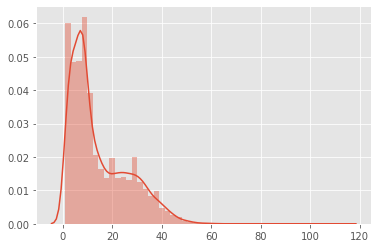

In [46]:
import seaborn as sns

length=[len(s) for s in sentences]
sns.distplot(length)
print(f'Maximum sentence length: {max(length)}')


In [10]:
# List of tags
tags=df["List2"].values.tolist()

In [11]:
# List of sentences and tags for validation ( Tesz Dataset)

val_sentences=val_df["List1"].values.tolist()
val_tags=val_df["List2"].values.tolist()

### Tokenizer Function

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers
(each integer being the index of a token in a dictionary) or into a vector where the coefficient for 
 each token could be binary, based on word count, based on tf-idf

#### texts_to_sequences
Transforms each text in texts to a sequence of integers.
So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index

#### pad_sequences 

It is used to ensure that all sequences in a list have the same length. By default this is done by padding 0
in the beginning of each sequence until each sequence has the same length as the longest sequence

In [12]:


word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(sentences)  
# number of common words: here we have 21010 common words
common_words = len(word_tokenizer.word_index) + 1
embedded_sentences = word_tokenizer.texts_to_sequences(sentences)
#finds maximum length in order to do padding so all sentences will be equal in length
max_len=max([len(seq) for seq in embedded_sentences]) 
#pad_sequences is used to ensure that all sequences in a list have the same length. By default this is done by padding 0
#in the beginning of each sequence until each sequence has the same length as the longest sequence
X=np.array(pad_sequences(embedded_sentences,padding='post'))


#same as above methods (NER tags preparation)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(tags)
embedded_labels = label_tokenizer.texts_to_sequences(tags)
y=np.array(pad_sequences(embedded_labels,padding='post'))
max_len_labels=len(label_tokenizer.word_index)+1



    

In [13]:

# to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
y = [to_categorical(i, num_classes=max_len_labels) for i in y]
X_tr=X
y_tr=y

In [14]:
X_tr[0]

array([  988, 10950,   204,   628,     6,  3938,   215,  5773,     2,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [15]:
print(y_tr[0])
print('\n........Open the list........\n')
for i in range(0,9):
    print(y_tr[0][i])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]

........Open the list........

[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]


### Functions to find recall, precision and F1 measure

#### recall
In addition to true positives it also takes into account the positive tags that were missed,
and therefore mistakenly replaced with negative ones (i.e., false negatives)

#### precision
 takes into account only the number of correctly assigned labels, i.e., the true positives

#### f-score
It is a combination of precision and recall

#### accuracy
 indicates the proportion of true results (both true positives and true negatives) in the population,
 which also includes false positives and false negatives

In [16]:

from keras import backend as K


def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon()) #we use epsilon, to handle 'divided by zero' condition.
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Model Setup

###  Bi-LSTM network with an embedding layer

inputs: The input(s) of the model: a keras.Input object or list of keras.Input objects. <br/>

output_dim: Integer. Dimension of the dense embedding.<br />

input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed). <br />

The first hidden layer will have 100 memory units and the output layer will be a fully connected layer that 
outputs one value per timestep.

TimeDistributed wrapper layer is used around the output layer so that one value per timestep can be predicted given
the full sequence provided as input. This requires that the LSTM hidden layer returns a sequence of values (one per timestep)
rather than a single value for the whole input sequence.<br />
Softmax function: “returns a probability distribution over the target classes in a multiclass classification problem”  <br />

This is a multi-class classification problem, the categorical log loss (categorical_crossentropy in Keras) is used.
The efficient ADAM optimization algorithm isused to find the weights and the accuracy metric is calculated and reported
each epoch.

In [17]:

input = Input(shape=(max_len,))
model = Embedding(input_dim=common_words, output_dim=max_len, input_length=max_len)(input)  # 113-dim embedding
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(model)  # variational biLSTM
out = TimeDistributed(Dense(max_len_labels, activation="softmax"))(model)  # softmax output layer
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m])

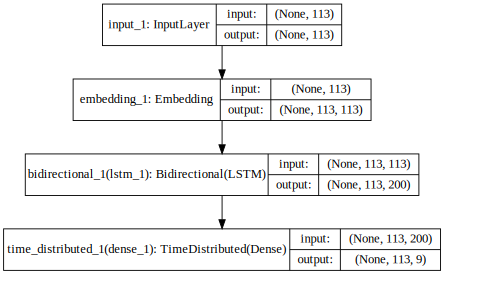

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
def plot_keras_model(model, show_shapes=True,  show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names, dpi=65).create(prog='dot',format='svg'))
plot_keras_model(model, show_shapes=True, show_layer_names=True)

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 113)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 113, 113)          2374130   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 113, 200)          171200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 113, 9)            1809      
Total params: 2,547,139
Trainable params: 2,547,139
Non-trainable params: 0
_________________________________________________________________


The LSTM will be trained for 5 epochs.
One epoch is when an entire dataset is passed both forward and backward through the neural network only once
The validation split variable in Keras is a value between [0..1]. Keras proportionally split your training set 
by the value of the variable.The first set is used for training and the 2nd set for validation after each epoch.

In [20]:

history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=10, validation_split=0.1, verbose=1)


C:\Users\gujabeen\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12636 samples, validate on 1405 samples
Epoch 1/10
12636/12636 [==============================] - 87s 7ms/step - loss: 0.1452 - accuracy: 0.9668 - f1_m: 0.9502 - precision_m: 0.9596 - recall_m: 0.9453 - val_loss: 0.0529 - val_accuracy: 0.9840 - val_f1_m: 0.9855 - val_precision_m: 0.9922 - val_recall_m: 0.9788
Epoch 2/10
12636/12636 [==============================] - 106s 8ms/step - loss: 0.0370 - accuracy: 0.9882 - f1_m: 0.9888 - precision_m: 0.9966 - recall_m: 0.9810 - val_loss: 0.0369 - val_accuracy: 0.9896 - val_f1_m: 0.9898 - val_precision_m: 0.9952 - val_recall_m: 0.9846
Epoch 3/10
12636/12636 [==============================] - 89s 7ms/step - loss: 0.0182 - accuracy: 0.9950 - f1_m: 0.9949 - precision_m: 0.9973 - recall_m: 0.9926 - val_loss: 0.0312 - val_accuracy: 0.9911 - val_f1_m: 0.9912 - val_precision_m: 0.9932 - val_recall_m: 0.9892
Epoch 4/10
12636/12636 [==============================] - 91s 7ms/step - loss: 0.0113 - accuracy: 0.9968 - f1_m: 0.9968 - precision_m: 0.

In [21]:
hist = pd.DataFrame(history.history) # Saving all data from the model in dataframe to interpret results

# Visualization of results

In [22]:
def visualize_results(value, vali_value, label):
    plt.plot(value)
    plt.plot(vali_value)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.title(label)
    plt.show()

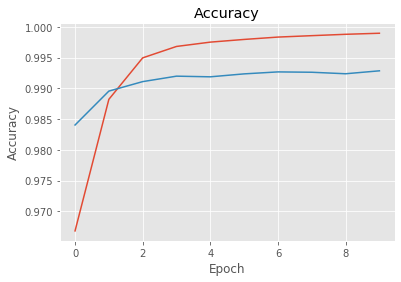

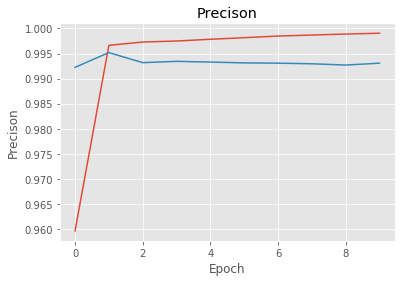

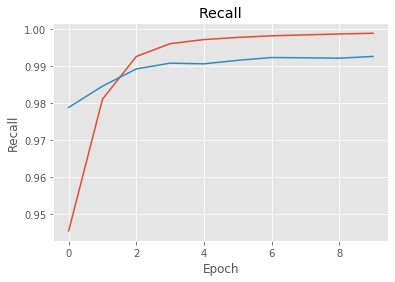

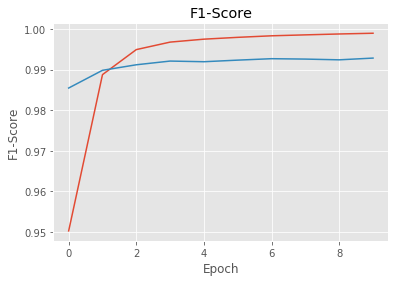

In [23]:
visualize_results(hist["accuracy"], hist["val_accuracy"], 'Accuracy')
visualize_results(hist["precision_m"], hist["val_precision_m"], 'Precison')
visualize_results(hist["recall_m"], hist["val_recall_m"], 'Recall')
visualize_results(hist["f1_m"], hist["val_f1_m"], 'F1-Score')

# Evaluation of the model

In [24]:
from sklearn.metrics import classification_report, confusion_matrix


In [25]:
def add_padding_sentences(sentence,max_length): 
    val_input_sequences=word_tokenizer.texts_to_sequences(sentence) #padding
    val_input_sequences=np.array(pad_sequences(val_input_sequences,padding='post', maxlen=max_length))
    return val_input_sequences
def add_padding_labels(labels,max_length):
    val_tag_sequence=label_tokenizer.texts_to_sequences(labels)
    val_tag_sequence=np.array(pad_sequences(val_tag_sequence,padding='post', maxlen=max_length))
    return val_tag_sequence
def predict_model(sequences): #predict 
    test_pred=model.predict(sequences)
    test_pred=test_pred.argmax(axis=-1)
    return test_pred
def flatten_values(value): 
    y_true_=value.flatten()
    return_index= np.vectorize(label_tokenizer.index_word.get)(y_true_)
    return return_index


In [26]:
val_input_sequences=add_padding_sentences(val_sentences,max_len)
val_tag_sequences= add_padding_labels(val_tags,max_len)
test_pred = predict_model(val_input_sequences)
y_true_index=flatten_values(val_tag_sequences)
test_pred_index=flatten_values(test_pred)
print(classification_report(y_true_index, test_pred_index))

C:\Users\gujabeen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        None       0.99      1.00      0.99    343765
       b-loc       0.00      0.00      0.00         6
      b-misc       0.00      0.00      0.00         9
       b-org       0.00      0.00      0.00         5
       i-loc       0.48      0.46      0.47      1918
      i-misc       0.54      0.45      0.49       909
       i-org       0.73      0.49      0.58      2490
       i-per       0.66      0.28      0.40      2771
           o       0.90      0.85      0.87     38316

    accuracy                           0.97    390189
   macro avg       0.48      0.39      0.42    390189
weighted avg       0.97      0.97      0.97    390189



In [34]:
Pred_df=pd.DataFrame({
    
    "Word": val_input_sequences.flatten(),
    "true": val_tag_sequences.flatten(),
    "pred": test_pred.flatten()
    
})

def token_to_word(token):
    if token!=0:
        return word_tokenizer.index_word[token]
    else:
        return ''
def label_token_to_word(token):
     if token!=0:
        return label_tokenizer.index_word[token]
     else:
        return ''
    
Pred_df.Word = Pred_df.Word.apply(token_to_word)
Pred_df.true = Pred_df.true.apply(label_token_to_word)
Pred_df.pred = Pred_df.pred.apply(label_token_to_word)



    

In [57]:
Pred_df[(Pred_df.Word !=',') &(Pred_df.Word !='') & (Pred_df.true != 'o' )].iloc[:50]

,Word,true,pred
2,japan,i-loc,i-loc
7,china,i-per,i-loc
228,arab,i-loc,i-loc
229,emirates,i-loc,i-loc
339,japan,i-loc,i-loc
345,asian,i-misc,i-misc
346,cup,i-misc,i-misc
354,syria,i-loc,i-loc
453,china,i-loc,i-loc
475,.,i-loc,o


#### Observations

- None: None has high value because of padding layer. In order to avoid it we need to add mask_zero=True in embedding layer. 
- Following tags has been predicted:iloc, i-misc, i-org, i-per <br/>
- Other tags have not been found, we need more state-of-the-art method to improve our results. As CRF can find more patterns within a text
so I tried it but didnt get good results because mistakenly I haved used old version which was  deprecated. <br/>
- This model could improve more if we use character embedding or GloVe embeddings.
- Bert Model could improve the results. (state of the art method)

